# Library import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from sklearn.preprocessing import scale, normalize
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics
from imblearn.over_sampling import SMOTE
sns.set(style="whitegrid")

# Data import & exploration

In [57]:
df = pd.read_csv("data_one_week_cleaned.csv", low_memory=False)
df.drop('auction_id',axis = 1, inplace = True)
print("Taille :",df.shape)

Taille : (44283, 77)


In [12]:
df.head()

,click,exchange,app_or_site,has_gps,device_type,connection_type,has_ifa,win_price,win_price_loc,bidder_name,...,Timestamp_second,Timestamp_minute,Timestamp_hour,Timestamp_DayOfWeek,Timestamp_DayOfMonth,Timestamp_Month,Days_Since_Campaign_Starts,Days_Before_Campaign_Ends,Campaign_Duration,creative_size
0,0,mopub,app,True,4,2,True,0.15000,0.15000,albatros,...,2,16,23,5,15,8,76,46,122,300x250
1,0,rubicon,app,True,1,2,True,5.04214,4.54997,butor,...,59,17,21,6,16,8,8,106,114,300x250
2,0,mopub,app,True,4,6,True,4.73000,4.26495,albatros,...,42,32,23,7,17,8,38,14,52,320x480
3,0,teads,site,True,4,unknown,False,6.00000,6.00000,albatros,...,6,15,22,6,16,8,3,15,18,300x250
4,0,mopub,app,True,4,6,True,1.39000,1.39000,butor,...,6,27,5,4,21,8,34,63,97,320x480


In [8]:
df.columns

Index(['click', 'exchange', 'app_or_site', 'has_gps', 'device_type',
       'connection_type', 'has_ifa', 'win_price', 'win_price_loc',
       'bidder_name', 'Device_language', 'Country_language',
       'Device_lg_Equals_country_lg', 'Continent', 'Country_code',
       'Country_name', 'City', 'Timestamp', 'IAB1', 'IAB1%', 'IAB10', 'IAB11',
       'IAB12', 'IAB13', 'IAB14', 'IAB15', 'IAB16', 'IAB17', 'IAB18', 'IAB19',
       'IAB2', 'IAB20', 'IAB21', 'IAB22', 'IAB23', 'IAB24', 'IAB3', 'IAB3%',
       'IAB4', 'IAB5', 'IAB6', 'IAB7', 'IAB8', 'IAB9', 'IAB9%', 'books',
       'busin', 'educa', 'enter', 'finan', 'games', 'healt', 'lifes', 'medic',
       'music', 'navig', 'news', 'photo', 'produ', 'refer', 'socia', 'sport',
       'trave', 'unkno', 'utili', 'weath', 'fullOsInfo', 'Timestamp_second',
       'Timestamp_minute', 'Timestamp_hour', 'Timestamp_DayOfWeek',
       'Timestamp_DayOfMonth', 'Timestamp_Month', 'Days_Since_Campaign_Starts',
       'Days_Before_Campaign_Ends', 'Campaign_

# Data preprocessing

In [20]:
# Timestamp columns drop. For Timestamp_Month, it's because of the data are in one week ==> one level
df.drop(['Timestamp_second','Timestamp_minute','Timestamp', 'Timestamp_Month'], axis = 1, inplace = True)

In [58]:
# Separate variable into binair, multi categorie and numeric
col = df.columns
bin_var = []
M_cat_var = []
num_var = []
for el in col:
    if(len(df[el].unique()) == 2):
        bin_var.append(el)
    elif ((2 < len(df[el].unique()) < 40)):
        M_cat_var.append(el)
    else:
        num_var.append(el)
print("Variable binaires : ", len(bin_var), "\nVariable Catégorielle :",
      len(M_cat_var), "\nVariable numéirque :", len(M_cat_var))

Variable binaires :  53 
Variable Catégorielle : 14 
Variable numéirque : 14


## Binary variable

In [21]:
df[bin_var].head()

,click,app_or_site,has_gps,has_ifa,Device_lg_Equals_country_lg,IAB1,IAB1%,IAB10,IAB11,IAB12,...,news,photo,produ,refer,socia,sport,trave,unkno,utili,weath
0,0,app,True,True,False,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,app,True,True,True,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,app,True,True,False,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,site,True,False,False,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,app,True,True,False,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


In [59]:
# Let's binarize some variable

df.app_or_site = [1 if el == 'app' else 0 for el in df.app_or_site]
df.has_gps = [1 if el == True else 0 for el in df.has_gps]
df.has_ifa = [1 if el == True else 0 for el in df.has_ifa]
df.Device_lg_Equals_country_lg = [
    1 if el == True else 0 for el in df.Device_lg_Equals_country_lg]

## Multicategorical var

In [60]:
# See the number of level for each var
for el in M_cat_var:
    print(el, len(df[el].unique()))

exchange 12
device_type 4
connection_type 7
bidder_name 3
Device_language 38
Country_language 18
Continent 5
Country_code 35
Country_name 35
fullOsInfo 24
Timestamp_hour 24
Timestamp_DayOfWeek 7
Timestamp_DayOfMonth 10
creative_size 10


### Let's explore the level of multi categorical variable

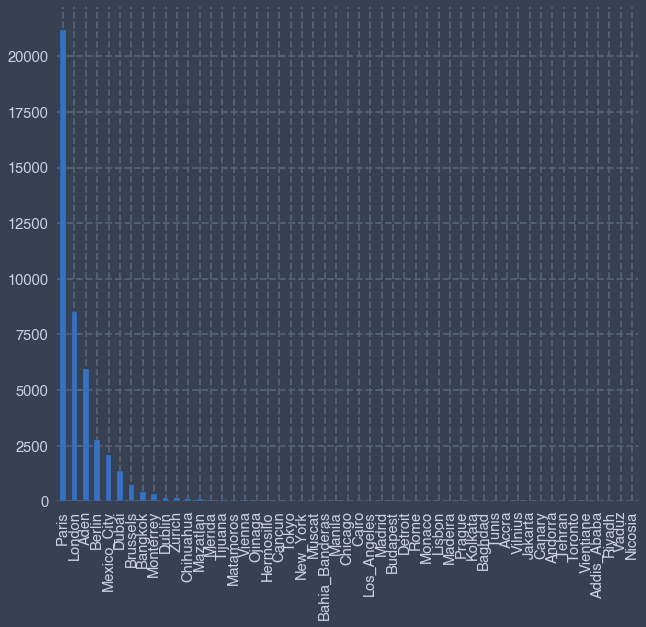

In [30]:
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
df.City.value_counts().plot(kind = 'bar')

In [73]:
df.drop(['Country_name', 'Country_language','win_price_loc', 
         'Device_language', 'City' ], axis = 1, inplace = True)

KeyError: "['Country_name' 'Country_language' 'win_price_loc' 'Device_language'\n 'City'] not found in axis"

In [62]:
df.device_type.value_counts()

4          40665
1           1899
5           1718
unknown        1
Name: device_type, dtype: int64

In [63]:
# Change the level of device type as it contain 6 level in stead of 4
df.device_type = df.device_type.replace('1', 1)
df.device_type = df.device_type.replace('4', 4)
df.device_type = df.device_type.replace('5', 5)

# Drop the unknow device type row
df.drop(df[df['device_type'] == 'unknown'].index, axis=0, inplace=True)

In [64]:
# Convert numeric variable into categoy

df.device_type = df.device_type.astype('category')
df.Timestamp_DayOfWeek = df.Timestamp_DayOfWeek.astype('category')
df.Timestamp_DayOfMonth = df.Timestamp_DayOfMonth.astype('category')

In [65]:
# Discrétisation of the hour
# 0h - 8h = Nuit
# 8h - 12h = Matin
# 12h - 18h = Après-midi
# 18h - 0h = Soir 
df.Timestamp_hour = pd.cut(df.Timestamp_hour, [0, 8,12,18,24], labels=['nuit','Matin','Aprem','Soir'])

In [69]:
M_cat_var = [x for x in df.columns if x not in M_cat_var ]
df[M_cat_var].head()

,exchange,device_type,connection_type,bidder_name,Continent,Country_code,fullOsInfo,Timestamp_hour,Timestamp_DayOfWeek,Timestamp_DayOfMonth,creative_size
0,mopub,4,2,albatros,Asia,AE,iOS_12,Soir,5,15,300x250
1,rubicon,1,2,butor,Europe,DE,iOS_12,Soir,6,16,300x250
2,mopub,4,6,albatros,Europe,FR,Android_8,Soir,7,17,320x480
3,teads,4,unknown,albatros,America,CA,iOS_12,Soir,6,16,300x250
4,mopub,4,6,butor,Asia,YE,iOS_11,nuit,4,21,320x480


In [70]:
a = df.columns
b = []
c = []
d = []
s = 0
for el in a :
    if (len(df[el].unique()) > 40):
        b.append(el)
    elif (len(df[el].unique()) == 2):
        d.append(el)
    else:
        c.append(el)
for el in c:
    s+= len(df[el].unique())
s+=len(b)+len(d)
print(s)

182


## Numeric Variable

In [72]:
for el in num_var:
    print(el)

win_price
win_price_loc
City
Timestamp
Timestamp_second
Timestamp_minute
Timestamp_Month
Days_Since_Campaign_Starts
Days_Before_Campaign_Ends
Campaign_Duration


In [302]:
# Change some varaible as numeric
df.Days_Before_Campaign_Ends = scale(df.Days_Before_Campaign_Ends)
df.Days_Since_Campaign_Starts = scale (df.Days_Since_Campaign_Starts)
df.Campaign_Duration = scale (df.Campaign_Duration)
df.win_price = scale(df.win_price)

### Dummification

In [21]:
data = pd.get_dummies(df)
data.shape

KeyboardInterrupt: 

In [491]:
data.head()

,click,app_or_site,has_gps,has_ifa,win_price,Device_lg_Equals_country_lg,IAB1,IAB1%,IAB10,IAB11,...,creative_size_1024x768,creative_size_300x100,creative_size_300x250,creative_size_300x50,creative_size_300x600,creative_size_320x480,creative_size_320x50,creative_size_480x320,creative_size_728x90,creative_size_768x1024
0,0,1,1,1,0.15000,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,1,1,1,5.04214,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,1,1,1,4.73000,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,6.00000,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,1,1,1,1.39000,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### SVD for dimensionnal reduction

In [493]:
svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42)
X = data.drop('click', axis = 1)
X_normalised = normalize(X)
X_transform = svd.fit_transform(X_normalised)
print("Pourcentage d'inertie : ", svd.explained_variance_ratio_.sum())

Pourcentage d'inertie :  0.965124248132476


In [494]:
X = pd.DataFrame(X_transform)
X.isna().values.any()

False

In [496]:
X.shape, data.shape

((44282, 20), (44282, 177))

In [20]:
dataF = pd.concat([data.click, X], axis=1)
dataF.isna().values.any()

NameError: name 'data' is not defined

In [506]:
dataF = dataF.dropna()

In [19]:
dataF.click.value_counts().plot(kind = 'bar')

NameError: name 'dataF' is not defined

In [484]:
dataF = dataF.dropna()

In [509]:
dataF.head()

,click,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0.0,0.990205,0.121008,-0.045353,-0.032842,-0.008076,-0.029217,0.000360,0.013391,0.008801,...,-0.010007,0.002332,-0.001921,-0.001095,0.000504,0.002366,-0.002845,-0.002201,0.001887,0.002933
1,0.0,0.884851,-0.460907,-0.053043,0.000349,-0.020747,-0.022531,0.019192,-0.001143,-0.002500,...,0.003263,0.000250,0.002502,0.005664,0.001025,0.000640,0.000030,-0.002933,0.000265,0.009653
2,0.0,0.969286,0.231391,0.038388,-0.044382,-0.017785,-0.024780,-0.001226,0.009349,0.000162,...,-0.016332,0.008046,-0.001225,-0.000810,0.002818,-0.000311,-0.005628,-0.003443,0.013801,-0.008909
3,0.0,0.899129,-0.381856,0.163204,-0.066519,-0.025876,0.017934,0.012588,0.010846,-0.033917,...,-0.032582,0.007437,-0.017372,-0.010677,-0.028744,0.016559,0.002471,-0.009322,-0.008100,0.006153
4,0.0,0.979364,-0.188205,-0.057741,-0.016758,-0.009486,-0.028262,0.005566,0.000944,0.001082,...,0.002289,0.007639,0.007379,0.010156,0.003435,-0.004235,-0.003790,-0.002693,0.003173,0.006265


# Train test split

In [510]:
train, test =train_test_split(dataF,  test_size=0.33, random_state=42)
y_train = train.click.astype('int64')
y_test = test.click
x_train = train.drop('click', axis = 1)
x_test = test.drop('click',  axis = 1)

In [432]:
y_train.shape, x_train.shape, x_test.shape, y_test.shape

((29669,), (29669, 30), (14614, 30), (14614,))

# Modelization v1

In [511]:
mod1 = LogisticRegression()
mod1.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [512]:
mod1.score(x_test,y_test)

0.9911038116745363

### Confusion matrix

In [513]:
pred1 = mod1.predict(x_test)
cm1 = metrics.confusion_matrix(y_test, pred1)
print(cm1)

[[14483     0]
 [  130     0]]


In [345]:
print(classification_report(y_test, pred1, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     14494
           1       0.00      0.00      0.00       120

    accuracy                           0.99     14614
   macro avg       0.50      0.50      0.50     14614
weighted avg       0.98      0.99      0.99     14614



/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Imbelencing problem fixe

In [515]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(x_train, y_train)

In [15]:
y_train.value_counts().plot(kind = 'bar')

NameError: name 'y_train' is not defined

# Modelization v2

In [517]:
mod2 = LogisticRegression()
mod2.fit(X_train, y_train)
pred2 = mod2.predict(x_test)
score2 = mod2.score(x_test, y_test)
print(score2)

0.6351194142202149


In [518]:
print(classification_report(y_test, pred2, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.99      0.64      0.78     14483
           1       0.01      0.62      0.03       130

    accuracy                           0.64     14613
   macro avg       0.50      0.63      0.40     14613
weighted avg       0.99      0.64      0.77     14613



In [519]:
cm2 = metrics.confusion_matrix(y_test, pred2)
print(cm2)

[[9201 5282]
 [  50   80]]


### ROC curve

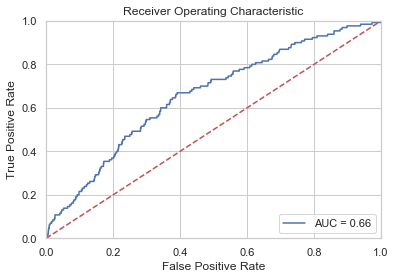

In [520]:
# calculate the fpr and tpr for all thresholds of the classification
probs = mod2.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Mod 2 improvement

In [523]:
logistic = LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2', 'elasticnet']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

max_iter = [100, 200, 300, 400, 500]

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty, max_iter= max_iter)

clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
# Fit grid search
best_model = clf.fit(X_train, y_train)

/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFaile

/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  

/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  

/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  

/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedW

/Users/omarseck/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)


In [524]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best max_iter:', best_model.best_estimator_.get_params()['max_iter'])

Best Penalty: l2
Best C: 7.742636826811269
Best max_iter: 100


In [525]:
mod3 = LogisticRegression(penalty = 'l2', C = 7.742636826811269, max_iter = 100 )
mod = mod3.fit(X_train, y_train)
pred3 = mod3.predict(x_test)

In [526]:
scoreTest = mod3.score(x_test, y_test)
scoreTrain = mod3.score(X_train, y_train)
print("Score de Train : ", scoreTrain, 
     "\nScore de Test : ", scoreTest)

Score de Train :  0.663820668072658 
Score de Test :  0.6323821255046876


In [527]:
cm = metrics.confusion_matrix(y_test, pred3)
print(cm)

[[9157 5326]
 [  46   84]]


In [528]:
print(classification_report(y_test, pred3, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       1.00      0.63      0.77     14483
           1       0.02      0.65      0.03       130

    accuracy                           0.63     14613
   macro avg       0.51      0.64      0.40     14613
weighted avg       0.99      0.63      0.77     14613



In [544]:
metrics.f1_score(y_test, pred3)

0.030324909747292416

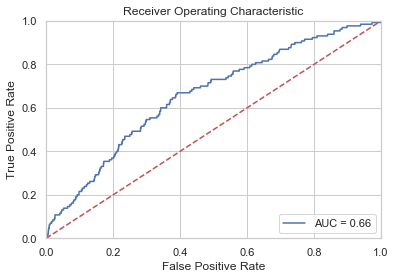

In [542]:
# calculate the fpr and tpr for all thresholds of the classification
probs = mod2.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()